In [1]:
# using Plots
using LinearAlgebra
using SparseArrays
using PyPlot
using WriteVTK
using ReadVTK

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [2]:
# test case 
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
z0 = 0
z1 = 1
ne = 10
ndim = 2
FunctionClass = "Q2";

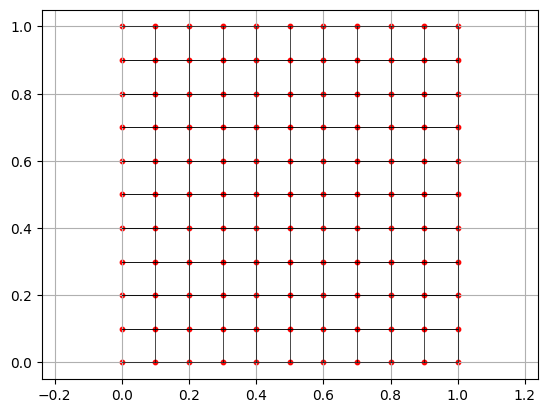

In [3]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

    NodeList = zeros(ndim,(ne+1)^ndim)
    IEN = zeros(Int64,ne^ndim,2^ndim)

    if ndim == 2
        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
    
        k = 1
        for i in 1:ne+1
            for j in 1:ne+1
                NodeList[1,k] = x[j]
                NodeList[2,k] = y[i]
                k = k + 1
            end
        end
        
        l = 1
        for i in 1:ne
            for j in 1:ne
                IEN[l,1] = (i-1)*(ne+1) + j
                IEN[l,2] = (i-1)*(ne+1) + j + 1
                IEN[l,3] = i*(ne+1) + j + 1
                IEN[l,4] = i*(ne+1) + j
                l = l + 1
            end
        end

    elseif ndim == 3

        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
        z = collect(range(z0, z1, length=ne+1))
        
        m = 1
        for k in 1:ne+1
            for j in 1:ne+1
                for i in 1:ne+1
                    NodeList[1,m] = x[i]
                    NodeList[2,m] = y[j]
                    NodeList[3,m] = z[k]
                    m = m + 1
                end
            end
        end
        
        l = 1
        for k in 1:ne
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,2] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,3] = (k-1)*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,4] = (k-1)*(ne+1)^2 + i*(ne+1) + j
                    IEN[l,5] = k*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,6] = k*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,7] = k*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,8] = k*(ne+1)^2 + i*(ne+1) + j
                    l = l + 1
                end
            end
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

if ndim == 2
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)

    for i in 1:size(IEN,1)
        x = NodeList[1,IEN[i,:]]
        y = NodeList[2,IEN[i,:]]
        ax.plot(x, y, "-k", linewidth=0.5)
    end

    ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
    ax.axis("equal")
    ax.grid("on")

elseif ndim == 3
    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection="3d")

    for i in 1:size(IEN,1)
        x = NodeList[1,IEN[i,:]]
        y = NodeList[2,IEN[i,:]]
        z = NodeList[3,IEN[i,:]]
        ax.plot(x, y, z,"-k", linewidth=0.5)
    end

    ax.scatter(NodeList[1,:],NodeList[2,:],NodeList[3,:],s=10,c="r")
    ax.axis("equal")
    ax.grid("on")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

end
gcf()

In [4]:
function basis_function(ξ,η=nothing,ζ=nothing, FunctionClass = "Q1")
    """ Define the basis functions and the gradients for a master element
        xi, eta, zeta are the coordinates of the point where the basis function is evaluated
        FunctionClass is the type of basis functions to be considered
        
        Returns:
        N: basis functions {[ndof] Vector{Float64}}
        Delta_N: gradient of the basis functions {[ndof,ndim] Matrix{Float64}}
    """
    
    if FunctionClass == "Q2"
        if !isnothing(η) # Considering a 2D master element
            # basis functions
            N = [(1-ξ)*ξ*(1-η)*η/4, 
                -ξ*(1+ξ)*(1-η)*η/4, 
                ξ*(1+ξ)*η*(1+η)/4, 
                -(1-ξ)*ξ*η*(1+η)/4,
                -(1-ξ)*(1+ξ)*(1-η)*η/2,
                ξ*(1+ξ)*(1-η)*(1+η)/2,
                (1-ξ)*(1+ξ)*η*(1+η)/2,
                -(1-ξ)*ξ*(1-η)*(1+η)/2,
                (1-ξ)*(1+ξ)*(1-η)*(1+η)] # gradient of the basis functions

            Delta_Nx = [(1-2*ξ)*(1-η)*η/4, 
                -(1+2*ξ)*(1-η)*η/4, 
                (1+2*ξ)*η*(1+η)/4, 
                -(1-2*ξ)*η*(1+η)/4,
                ξ*(1-η)*η,
                (1+2*ξ)*(1-η)*(1+η)/2,
                -ξ*η*(1+η),
                -(1-2*ξ)*(1-η)*(1+η)/2,
                -2*ξ*(1-η)*(1+η)] # dN/dξ gradient of the basis functions
            
            Delta_Ny = [(1-ξ)*ξ*(1-2*η)/4, 
                -ξ*(1+ξ)*(1-2*η)/4, 
                ξ*(1+ξ)*(1+2*η)/4, 
                -(1-ξ)*ξ*(1+2*η)/4,
                -(1-ξ)*(1+ξ)*(1-2*η)/2,
                -ξ*(1+ξ)*η,
                (1-ξ)*(1+ξ)*(1+2*η)/2,
                (1-ξ)*ξ*η,
                -(1-ξ)*(1+ξ)*2*η] # dN/dη gradient of the basis functions
        
            ΔN = [Delta_Nx Delta_Ny] # [dN/dξ dN/dη]
        end
    elseif FunctionClass == "Q1"
        if !isnothing(ζ) # Considering a 3D master element
            # basis functions
            N = [(1-ξ)*(1-η)*(1-ζ)/8, 
                (1+ξ)*(1-η)*(1-ζ)/8, 
                (1+ξ)*(1+η)*(1-ζ)/8, 
                (1-ξ)*(1+η)*(1-ζ)/8, 
                (1-ξ)*(1-η)*(1+ζ)/8, 
                (1+ξ)*(1-η)*(1+ζ)/8, 
                (1+ξ)*(1+η)*(1+ζ)/8, 
                (1-ξ)*(1+η)*(1+ζ)/8]

            # gradient of the basis functions
            ΔN = [[-(1-η)*(1-ζ)/8, (1-η)*(1-ζ)/8, (1+η)*(1-ζ)/8, -(1+η)*(1-ζ)/8, -(1-η)*(1+ζ)/8, (1-η)*(1+ζ)/8, (1+η)*(1+ζ)/8, -(1+η)*(1+ζ)/8] [-(1-ξ)*(1-ζ)/8, -(1+ξ)*(1-ζ)/8, (1+ξ)*(1-ζ)/8, (1-ξ)*(1-ζ)/8, -(1-ξ)*(1+ζ)/8, -(1+ξ)*(1+ζ)/8, (1+ξ)*(1+ζ)/8, (1-ξ)*(1+ζ)/8] [-(1-ξ)*(1-η)/8, -(1+ξ)*(1-η)/8, -(1+ξ)*(1+η)/8, -(1-ξ)*(1+η)/8, (1-ξ)*(1-η)/8, (1+ξ)*(1-η)/8, (1+ξ)*(1+η)/8, (1-ξ)*(1+η)/8]]  # [dN/dxi dN/deta dN/dzeta]
        elseif !isnothing(η) # Considering a 2D master element
            # basis functions
            N = [(1-ξ)*(1-η)/4, (ξ+1)*(1-η)/4, (1+ξ)*(η+1)/4, (1-ξ)*(1+η)/4]

            # gradient of the basis functions
            ΔN = [[-(1-η)/4 , (1-η)/4, (η+1)/4, -(1+η)/4] [-(1-ξ)/4, -(ξ+1)/4, (1+ξ)/4, (1-ξ)/4] ]
        else # Considering a 1D master element
            # basis functions
            N  = [0.5-0.5*ξ, 0.5+0.5*ξ]

            # gradient of the basis functions
            ΔN = [-0.5 0.5]
        end
    end
    return N, ΔN
end

basis_function (generic function with 4 methods)

In [5]:
function setboundaryCond(NodeList, ne, ndim)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)^ndim,1)
    q_n = zeros((ne+1)^ndim,1)
    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)^ndim,(ne+1)^ndim)

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[3] == Dbound2 # top boundary
            q_d[2] = 1
        end

        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end

    C = C[:,((ne+1)^(ndim-1)+1):((ne+1)^ndim-(ne+1)^(ndim-1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim);

BoundsError: BoundsError: attempt to access 2-element Vector{Float64} at index [3]

In [6]:
function gaussian_quadrature(a,b)
    """ Compute the nodes and weights for the Gaussian quadrature of order 2
        a, b are the limits of the integration interval
        
        Returns:    
        ξ: nodes {[nGaussPoints] Vector{Float64}}
        w: weights {[nGaussPoints] Vector{Float64}}
    """

    ξ = [-(b-a)/(2*sqrt(3))+(b+a)/2, (b-a)/(2*sqrt(3))+(b+a)/2]
    w = [(b-a)/2, (b-a)/2]
    return ξ, w
end

gaussian_quadrature (generic function with 1 method)

In [7]:
function assemble_system(ne, NodeList, IEN, ndim, FunctionClass)
    """ Assembles the finite element system. Returns the global stiffness matrix

        Returns:
        K: sparse stiffness matrix {[ndof,ndof] SparseMatrixCSC{Float64,Int64}}
    """
    # (I,J,V) vectors for COO sparse matrix

    if FunctionClass == "Q1"
        E = zeros(Int64, (2^2*ne)^ndim)
        J = zeros(Int64, (2^2*ne)^ndim)
        V = zeros(Float64, (2^2*ne)^ndim)
    elseif FunctionClass == "Q2"
        E = zeros(Int64, (3^ndim*ne)^ndim)
        J = zeros(Int64, (3^ndim*ne)^ndim)
        V = zeros(Float64, (3^ndim*ne)^ndim)  
    end
    # element loop
    if ndim == 2
        # gaussian quadrature points for the element [-1,1]x[-1,1] 
        ξ, w_ξ = gaussian_quadrature(-1,1)
        η, w_η = gaussian_quadrature(-1,1)
        
        wpoints = [w_ξ[1]*w_η[1], w_ξ[2]*w_η[1], w_ξ[2]*w_η[2], w_ξ[1]*w_η[2]]
        
        x = [ξ[1], ξ[2], ξ[2], ξ[1]]
        y = [η[1], η[1], η[2], η[2]]

    elseif ndim == 3
        # gaussian quadrature points for the element [-1,1]x[-1,1]x[-1,1] 
        ξ, w_ξ = gaussian_quadrature(-1,1)
        η, w_η = gaussian_quadrature(-1,1)
        ζ, w_ζ = gaussian_quadrature(-1,1)
        
        wpoints = [w_ξ[1]*w_η[1]*w_ζ[1], w_ξ[2]*w_η[1]*w_ζ[1], w_ξ[2]*w_η[2]*w_ζ[1], w_ξ[1]*w_η[2]*w_ζ[1], w_ξ[1]*w_η[1]*w_ζ[2], w_ξ[2]*w_η[1]*w_ζ[2], w_ξ[2]*w_η[2]*w_ζ[2], w_ξ[1]*w_η[2]*w_ζ[2]]
        
        x = [ξ[1], ξ[2], ξ[2], ξ[1], ξ[1], ξ[2], ξ[2], ξ[1]]
        y = [η[1], η[1], η[2], η[2], η[1], η[1], η[2], η[2]]
        z = [ζ[1], ζ[1], ζ[1], ζ[1], ζ[2], ζ[2], ζ[2], ζ[2]]
    end

    for e in 1:ne^ndim

        coords = NodeList[:,IEN[e,:]] # get the coordinates of the nodes of the element
        
        # integration loop
        for gp in 1:2^ndim
            N, ΔN = basis_function(x[gp], y[gp], nothing FunctionClass)

            Jac  = coords*ΔN # Jacobian matrix [dx/dxi dx/deta; dy/dxi dy/deta]

            w = wpoints[gp]*abs(det(Jac))
            invJ = inv(Jac)
            dNdX = ΔN*invJ
            
            szN = size(N,1) # number of basis functions
            # loop between basis functions of the element
            for i in 1:szN
                for j in 1:szN
                    inz = (szN)^2*(e-1) + szN*(i-1) + j # index for the COO sparse matrix
                    E[inz] = IEN[e,i] # row index 
                    J[inz] = IEN[e,j] # column index
                    V[inz] += w*dot(dNdX[i,:],dNdX[j,:])# inner product of the gradient of the basis functions
                end
            end
        end
    end

    K = sparse(E,J,V)

    return K
end

ErrorException: syntax: missing comma or ) in argument list

In [8]:
K = assemble_system(ne, NodeList, IEN, ndim, FunctionClass)

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

UndefVarError: UndefVarError: assemble_system not defined

In [9]:
PostProcess.write_vtk("vtkFiles/isoParam3d",NodeList,IEN, ne, ndim, q)

UndefVarError: UndefVarError: q not defined

In [10]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
qList = PostProcess.noramlize(q, IEN)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    c = qList[i,:]
    cmap = PostProcess.truncate_colormap(maximum(c), minimum(c))
    ax.tripcolor(x, y, c, cmap=cmap,shading="gouraud" )
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.axis("equal")
gcf()

UndefVarError: UndefVarError: q not defined